## The metastable states of a peptide in water solution

In [92]:
# import libraries
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy import linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 150

COLORS = np.array(['red', 'blue', 'green', 'black', 'purple', 'brown'])

def sorted_spectrum(matrix):
    eigenvalues, left_eigenvectors, right_eigenvectors = linalg.eig(matrix, left=True) # eigenvectors are the columns
    i = np.argsort(-eigenvalues)
    eigenvalues = np.real(eigenvalues[i])
    left_eigenvectors = np.real(left_eigenvectors[:, i])
    right_eigenvectors = np.real(right_eigenvectors[:, i])
    return eigenvalues, left_eigenvectors, right_eigenvectors

def pca(x: np.ndarray, dim: int = 'auto', variance_target: float = 0.99, normalize = False):    
    centered_x = x - np.mean(x, axis=0)
    if normalize:
        centered_x /= np.std(x, axis=0)
    cov = (centered_x.T).dot(centered_x)/len(x)
    evalues, evectors, _ = sorted_spectrum(cov)
    expl_variance = np.cumsum(evalues / np.sum(evalues))
    plt.plot(expl_variance, label = 'Cumulative explained variance')
    if dim=='auto':
        dim = np.sum(expl_variance < variance_target)
        
    
    plt.axvline(x=dim, color = 'red', label = f"Dimensionality reduction: {x.shape[1]} -> {dim}", alpha = 0.8, linestyle='--')
    plt.axhline(y=expl_variance[dim], color = 'gray', label = f"Explained variance: {expl_variance[dim]:.3g}", alpha = 0.8, linestyle='--')
    plt.legend()
    #print(f"Dimensionality reduction: {x.shape[1]} -> {dim}")
    #print(f"Explained variance: {expl_variance[dim]:.3f}")
    return centered_x.dot(evectors[:,:dim])

def show_transition_matrix(M):
    plt.imshow(M)
    if len(M) < 20:
        plt.xticks(np.arange(len(M)))
        plt.yticks(np.arange(len(M)))
    plt.colorbar()
    #print(np.round(M, 2))
    
distance = lambda x, y : np.sum((x-y)**2., axis=-1)

def kmeans(*, X: np.ndarray, k: int):
    centers = X[np.random.choice(np.arange(len(X)), k, replace=True)] # Forgy method
    labels = np.zeros(len(X))
    old_labels = labels - 1
    while np.any(old_labels != labels):
        D = distance(np.expand_dims(X, 1), np.expand_dims(centers, 0))
        old_labels = labels
        labels = np.argmin(D, axis=1)
        centers = np.array([np.mean(X[labels==i], axis=0) for i in range(k)])
    return (labels, centers)

In [59]:
# Download dataset
URL = "https://raw.githubusercontent.com/alexdepremia/Unsupervised-Learning-Datasets/main/high_variance_distances.dat.gz"
compressed_file_name = URL.split('/')[-1]
file_name = compressed_file_name[:-3]
if not os.path.exists('high_variance_distances.dat'):
    os.system(f'wget {URL}')
    os.system(f'gzip -d {compressed_file_name}')
    
# Load dataset
data = np.genfromtxt(file_name, delimiter=' ')

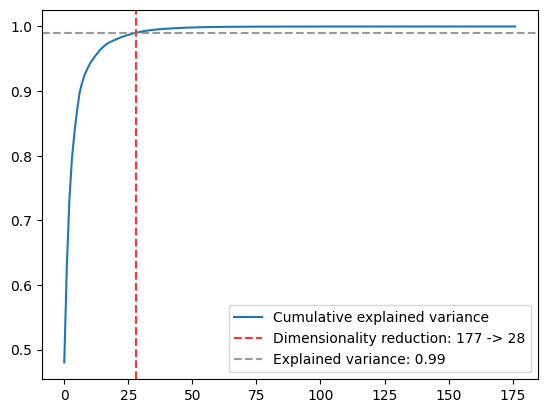

In [60]:
# Preliminary data processing
CENTER = True
NORMALIZE = False
PCA_VARIANCE_TARGET = 0.99

X = data

if CENTER:
    X -= X.mean(axis=0)
if NORMALIZE:
    X /= X.std(axis=0)
if PCA_VARIANCE_TARGET:
    X = pca(X, variance_target = PCA_VARIANCE_TARGET)

### Find the microstates by a cluster analysis performed with k-means or k-medoids.

In [153]:
#from sklearn.cluster import KMeans

N_CLUSTERS = 50

state, centers = kmeans(X=X, k=N_CLUSTERS)

#kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto").fit(X)
#state = kmeans.labels_
state -= np.min(state)

### Choose a time lag and estimate the transition matrix between each pair of clusters

In [167]:
TIME_LAG = 10

def get_transition_matrix(states: np.ndarray, time_lag: int) -> np.ndarray:
    frequency_matrix = confusion_matrix(states[:-time_lag], states[time_lag:])
    transition_matrix = frequency_matrix / np.expand_dims(frequency_matrix.sum(axis=1),1)
    np.testing.assert_almost_equal(transition_matrix.sum(axis=1), np.ones(len(transition_matrix)))
    #assert (transition_matrix>0).all()
    return transition_matrix
  
transition_matrix = get_transition_matrix(state, TIME_LAG)

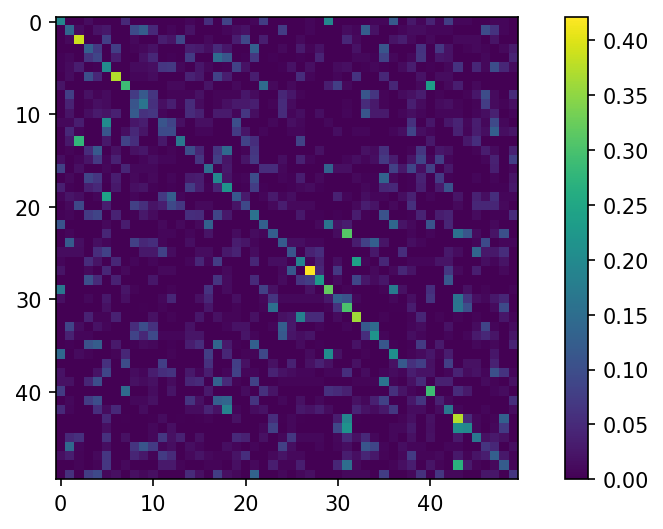

In [168]:
show_transition_matrix(transition_matrix)

### By analyzing the spectrum choose an appropriate number of Markov states. Find the Markov states by inspecting the sign of the eigenvectors.

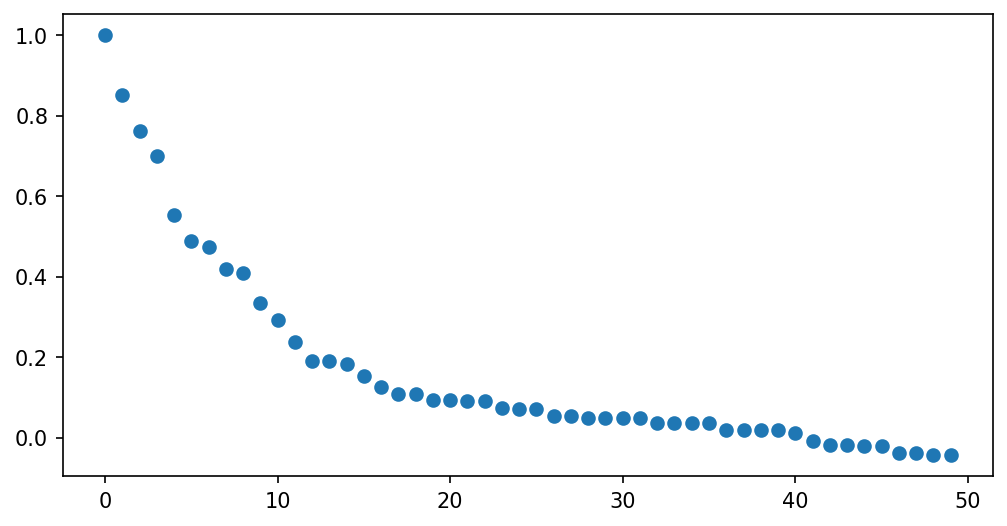

In [186]:
eigenvalues, left_eigenvectors, right_eigenvectors = sorted_spectrum(transition_matrix)

np.testing.assert_almost_equal(eigenvalues[0], 1)
#print(f"{eigenvalues=}")
#print(f"{left_eigenvectors=}")
#print(f"{right_eigenvectors=}")

stationary_solution = left_eigenvectors[:, 0] / left_eigenvectors[:, 0].sum()
np.testing.assert_allclose(stationary_solution.dot(transition_matrix), stationary_solution)
np.testing.assert_almost_equal((left_eigenvectors.sum(axis=0)[1:])**2, 0.)

_ = plt.scatter(np.arange(len(eigenvalues)), eigenvalues)

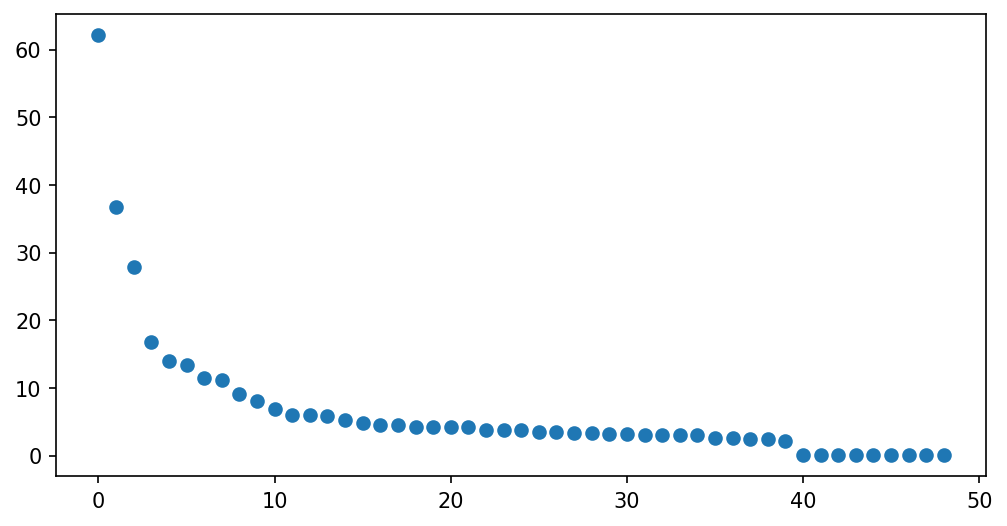

In [170]:
def get_relaxation_time(v, time_lag):
    x = v
    x[x<0] = 1e-99
    return -time_lag/np.log(x)

relaxation_times = get_relaxation_time(eigenvalues[1:], TIME_LAG)
_ = plt.scatter(np.arange(len(relaxation_times)), relaxation_times)

In [171]:
def to_markov_state(states: np.ndarray, left_eigvectors: np.ndarray, level: int =1):
    """
    Crazy one liner:
        - for each eigenvectors extract > 0 information, so turn eigenvetors matrix into binary (1, 0)
        - each row is interpreted as a binary number, so converted to decimal
        - apply modulo (2^level) in order to consider only first level eigenvectors
    """
    markov_states_map = np.sum(2**np.arange(left_eigvectors.shape[1]-1) * (left_eigenvectors[:,1:]>0)*1, axis=1)%(2**level)
    return markov_states_map, markov_states_map[states]

markov_states_map, markov_state = to_markov_state(states=state, left_eigvectors=left_eigenvectors, level=1)

print(f"{markov_states_map = }")
markov_states_dict = {mstate : list(np.arange(len(markov_states_map))[markov_states_map==mstate]) for mstate in np.unique(markov_states_map)}
print(f"{markov_states_dict = }")

markov_states_map = array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1])
markov_states_dict = {0: [0, 2, 5, 7, 11, 12, 13, 16, 19, 22, 23, 25, 29, 30, 31, 36, 37, 38, 40, 43, 44, 45, 47, 48], 1: [1, 3, 4, 6, 8, 9, 10, 14, 15, 17, 18, 20, 21, 24, 26, 27, 28, 32, 33, 34, 35, 39, 41, 42, 46, 49]}


[[0.88 0.12]
 [0.11 0.89]]


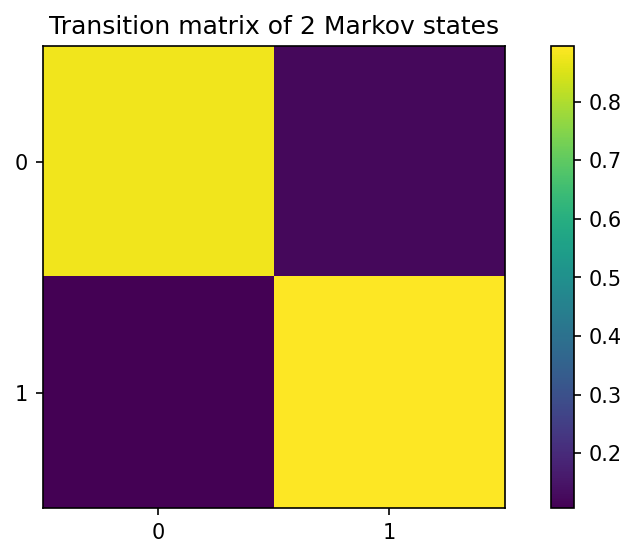

In [175]:
_, markov_state = to_markov_state(states=state, left_eigvectors=left_eigenvectors, level=1)
tm = get_transition_matrix(markov_state, time_lag = TIME_LAG)
show_transition_matrix(tm)
_ = plt.title(f"Transition matrix of {len(set(markov_state))} Markov states")
print(np.round(tm, 2))

[[0.75 0.09 0.14 0.02]
 [0.03 0.76 0.04 0.17]
 [0.06 0.03 0.81 0.1 ]
 [0.01 0.22 0.14 0.63]]


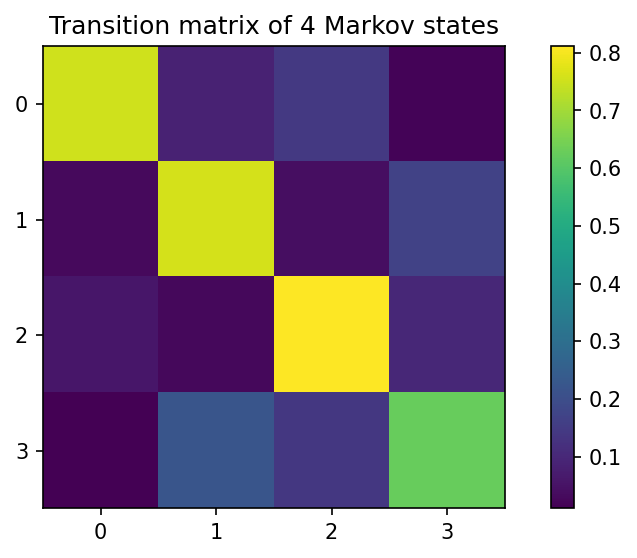

In [176]:
_, markov_state = to_markov_state(states=state, left_eigvectors=left_eigenvectors, level=2)
tm = get_transition_matrix(markov_state, time_lag = TIME_LAG)
show_transition_matrix(tm)
_ = plt.title(f"Transition matrix of {len(set(markov_state))} Markov states")
print(np.round(tm, 2))

### Perform a dimensional reduction with a method of your choice, retaining only two coordinates, and visualize the Markov states in the space of these coordinates.

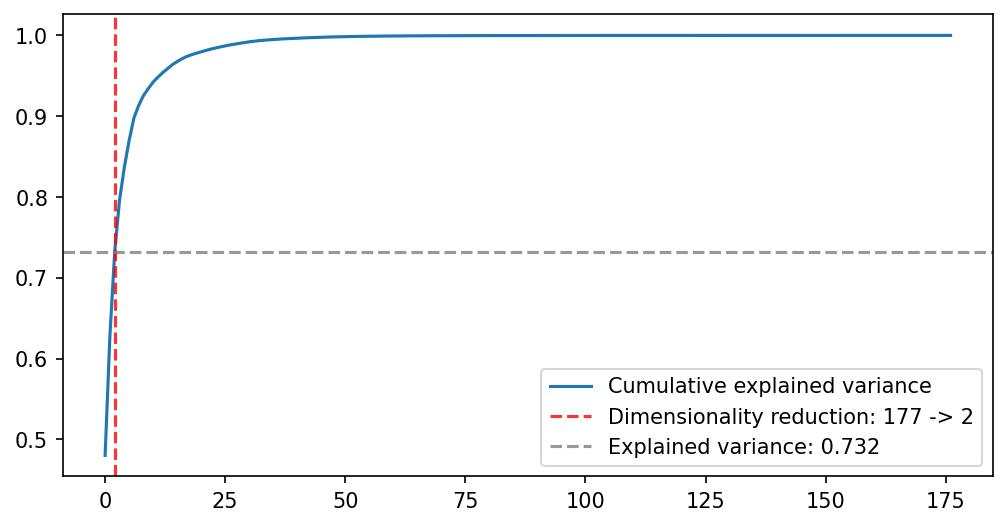

In [177]:
compressed_data = pca(data, dim=2, normalize=NORMALIZE)

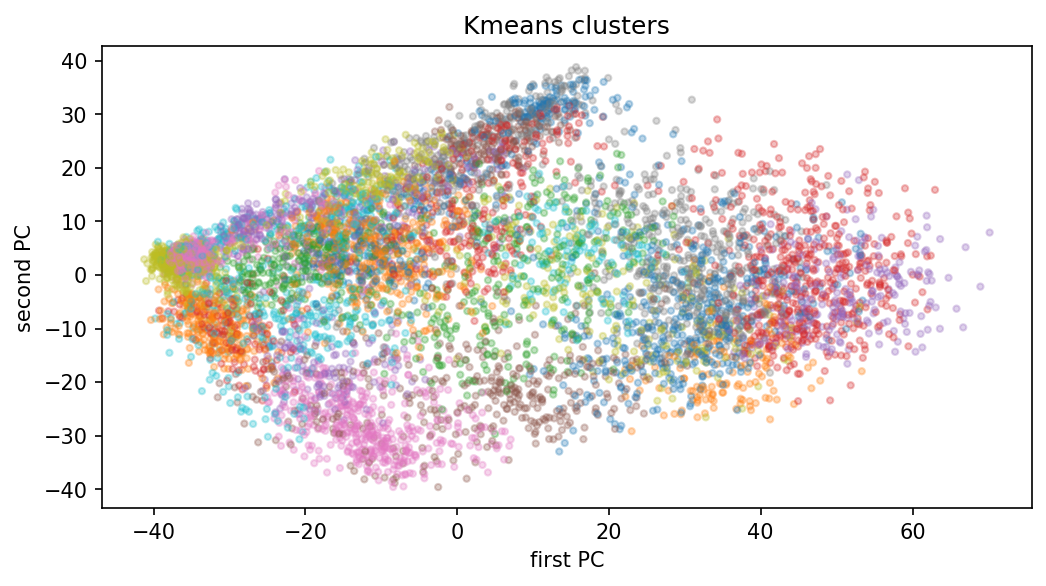

In [178]:
plt.scatter(compressed_data[:,0], compressed_data[:,1], c = state, alpha=0.3, cmap = 'tab10', marker = '.')
plt.xlabel('first PC')
plt.ylabel('second PC')
_ = plt.title(f'Kmeans clusters')

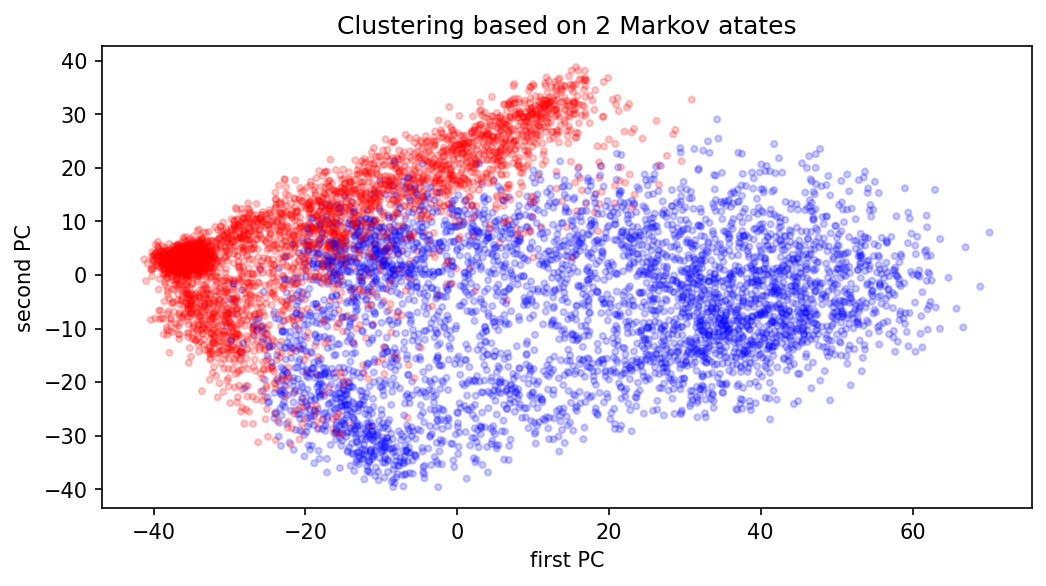

In [179]:
_, markov_state = to_markov_state(states=state, left_eigvectors=left_eigenvectors, level=1)
plt.scatter(compressed_data[:,0], compressed_data[:,1], c = COLORS[markov_state], alpha=0.2, marker = '.')
plt.xlabel('first PC')
plt.ylabel('second PC')
_ = plt.title(f'Clustering based on {len(set(markov_state))} Markov atates')

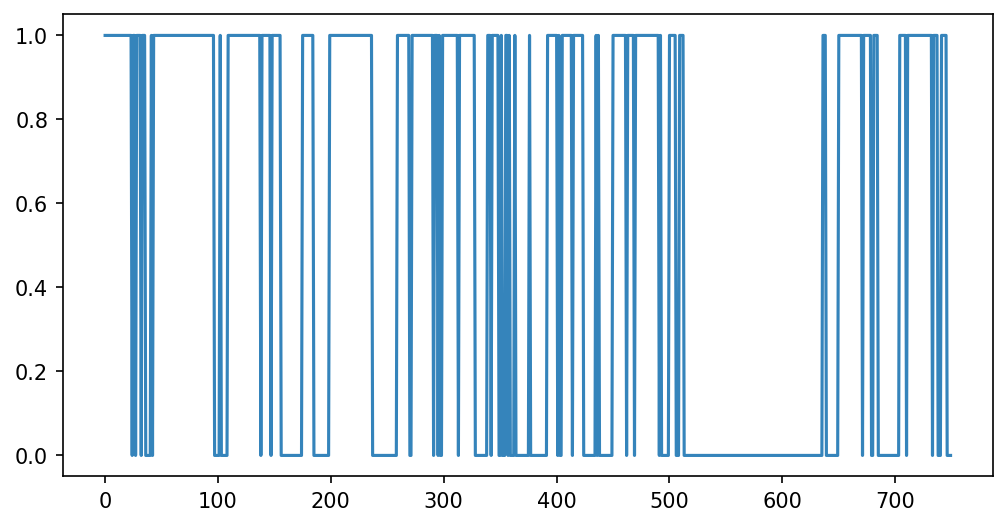

In [180]:
_ = plt.plot(markov_state[::TIME_LAG], '-', alpha = 0.9)

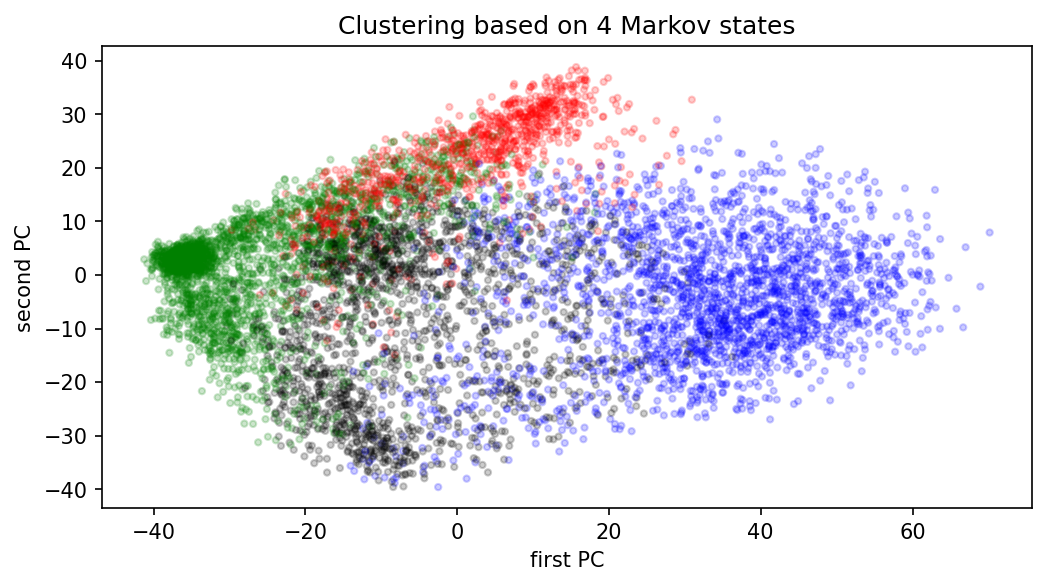

In [181]:
_, markov_state = to_markov_state(states=state, left_eigvectors=left_eigenvectors, level=2)
plt.scatter(compressed_data[:,0], compressed_data[:,1], c = COLORS[markov_state], alpha=0.2, marker = '.')
plt.xlabel('first PC')
plt.ylabel('second PC')
_ = plt.title(f'Clustering based on {len(set(markov_state))} Markov states')

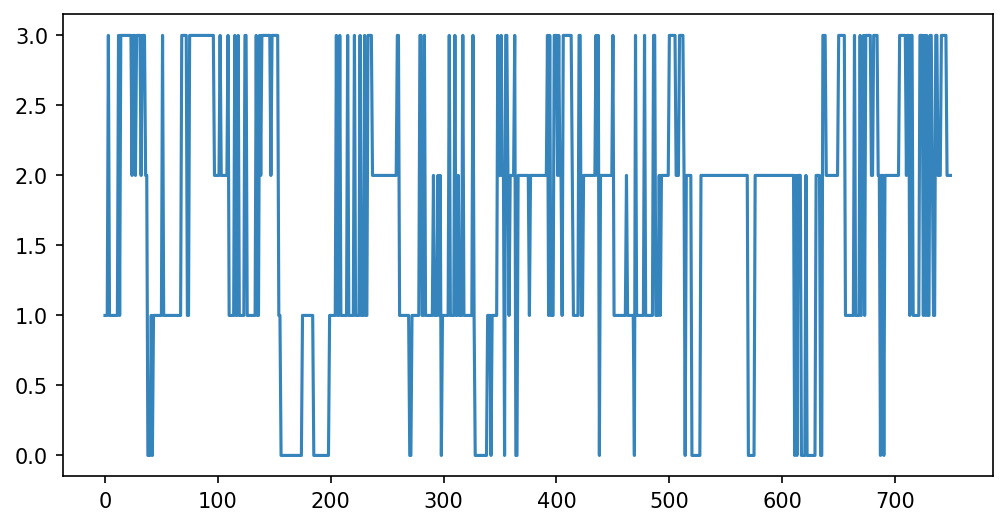

In [185]:
_ = plt.plot(markov_state[::TIME_LAG], '-', alpha = 0.9)

### Discuss the stability of the results with respect to the meta-parameters of the approach, in particular, the time lag τ and the number of clusters.

In [183]:
import gif

xmin = np.min(compressed_data[:,0])
xmax = np.max(compressed_data[:,0])
ymin = np.min(compressed_data[:,1])
ymax = np.max(compressed_data[:,1])
TAIL = 100


colors = np.where(markov_state==0, 'blue', 'red')

@gif.frame
def animate(t):
    plt.cla()
    s = slice(max(t+1-TAIL, 0), t+1)
    points = t+1 - max(t+1-TAIL, 0)

    plt.scatter(compressed_data[s,0], compressed_data[s,1], c = colors[s], alpha=1.2**(-np.arange(points)[::-1]), cmap = 'viridis')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
frames = [animate(i) for i in range(len(data))]
gif.save(frames, 'markov_states.gif', duration=240)

/tmp/ipykernel_3574/2224852494.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(compressed_data[s,0], compressed_data[s,1], c = colors[s], alpha=1.2**(-np.arange(points)[::-1]), cmap = 'viridis')


KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>